In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl

import flamedisx as fd

import os
import glob

import collections

2025-07-18 04:45:49.548162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752839149.574215 1676441 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752839149.581714 1676441 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752839149.624039 1676441 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752839149.624071 1676441 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752839149.624075 1676441 computation_placer.cc:177] computation placer alr

In [2]:
def get_disco_bands(directory):
    all_exposures = []
    all_bands = []
    
    subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and len(glob.glob(f'{f.path}/*.pkl')) > 0]
    for subfolder in subfolders:
        all_exposures.append(float(subfolder.split('_')[-1][:-2]))
    
        disco_sigs = pkl.load(open(f'{subfolder}/disco_sigs_0.pkl', 'rb'))
        intervals = fd.IntervalCalculator(signal_source_names=['WIMP'],
                                          stat_dists=disco_sigs)

        bands, mus = intervals.get_bands_discovery()
        all_bands.append(bands['WIMP'][mus['WIMP'][0]])

    return all_exposures, all_bands

In [3]:
def get_crossing(x, y, crit_val=5.):
    crossing_points = np.argwhere(np.diff(np.sign(y - np.ones_like(y) * crit_val)) > 0.).flatten()
    
    try:
        x_left = x[crossing_points[0]]
        x_right = x[crossing_points[0] + 1]
        y_left = y[crossing_points[0]]
        y_right = y[crossing_points[0] + 1]
    except:
        
        return x[-1]
    
    gradient = (y_right - y_left) / (x_right - x_left)


    return (crit_val - y_left) / gradient + x_left #re-arranged y-b = m(x-a) or (y-b)/m + a = x

In [21]:
files_titles = {'/global/homes/r/rory_m/rory_m/XLZD/FlameFitSimple/analyses/WIMP_discovery/outputs/WIMP_disco_0.1_all_tester/benchmark_0.1_LNGS': 'Benchmark parameters'}

In [22]:
def produce_plot(file, title):
    exposures, bands = get_disco_bands(directory=file)
    
    plt.figure()
    delta = 5

    medians = dict()
    for exposure, band in zip(exposures, bands):

        plt.plot([exposure-delta, exposure+delta],
                 2*[band[0]],
                 color='k', linewidth=2)
        plt.fill_between([exposure-delta, exposure+delta],
                         2*[band[-1]], 2*[band[1]],
                         facecolor='#00ff00', alpha=0.5)
        plt.fill_between([exposure-delta, exposure+delta],
                         2*[band[-2]], 2*[band[2]],
                         facecolor='#ffff00', alpha=0.5)

        medians[exposure] = band[0]

    medians = collections.OrderedDict(sorted(medians.items()))
    exposures = list(medians.keys())
    meds = list(medians.values())
    crossing = get_crossing(exposures, meds)
    
    plt.hlines(5., np.min(exposures), np.max(exposures), color='darkred', linestyle='--', linewidth=1)
    plt.text(np.min(exposures), 5.2, 'Discovery', color='darkred')

    plt.xlabel("Exposure [ty]")
    plt.ylabel("Discovery potential [$\sigma$]")
    plt.title(f"{title}: {crossing:.2f} ty")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0,10)
    ax = plt.gca()
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)

    #plt.ylim (0., 10.)

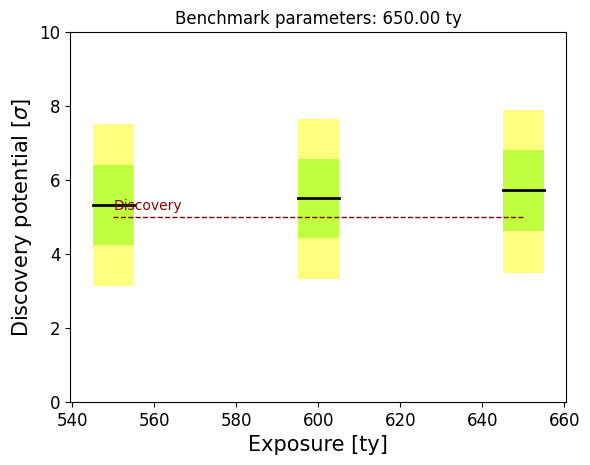

In [23]:
for file, title in files_titles.items():
    produce_plot(file, title)

## Obtaining error bars
Using the bootstrap method. Note, this only works when we have exposures very close together and with jumps in there variation (i.e. like seen [here](https://docs.google.com/presentation/d/18RPyFE89ghDNJHqrGblvD8VyR5j_uLPfgXyuzuR0P2c/edit?slide=id.g366bd46f492_0_10#slide=id.g366bd46f492_0_10))

In [24]:
def bootstrap_1_sigma_upper(arr, percentile=85, cl=68, N=1000):

    per = np.percentile(arr, percentile) 

    pers = [np.percentile(np.random.choice(arr, size=len(arr)), percentile) for _ in range(N)]
    pers = np.array(pers)

    perd = np.percentile(pers, 0.5*(100-cl))
    peru = np.percentile(pers, 100-0.5*(100-cl))
    
    return per, perd, peru

In [25]:
def bootstrap_1_sigma_lower(arr, percentile=15, cl=68, N=1000):

    per = np.percentile(arr, percentile) 

    pers = [np.percentile(np.random.choice(arr, size=len(arr)), percentile) for _ in range(N)]
    pers = np.array(pers)

    perd = np.percentile(pers, 0.5*(100-cl))
    peru = np.percentile(pers, 100-0.5*(100-cl))
    
    return per, perd, peru

In [26]:
for file, title in files_titles.items():
    exposures, bands = get_disco_bands(file)
    
    print(exposures)
    print(bands)
   
    medians = dict()
    upper_lims = dict()
    lower_lims = dict ()

    for exposure, band in zip(exposures, bands):

        medians[exposure] = band[0]             #obtains the median
        upper_lims[exposure] = band[1]          #Obtains the upper limit
        lower_lims[exposure] = band[-1]         #Obtains the lower limit

    medians = collections.OrderedDict(sorted(medians.items()))
    upper_lims = collections.OrderedDict(sorted(upper_lims.items()))
    lower_lims = collections.OrderedDict(sorted(lower_lims.items()))

    upper_limits = list(upper_lims.values())
    lower_limits = list(lower_lims.values())

    exposures = list(medians.keys())
    meds = list(medians.values())
    crossing = get_crossing(exposures, meds)

[550.0, 650.0, 600.0]
[{0: np.float64(5.317644555166982), 1: np.float64(6.4046133223704516), -1: np.float64(4.237275433033612), 2: np.float64(7.507548284893011), -2: np.float64(3.133398552044791)}, {0: np.float64(5.729583277620771), 1: np.float64(6.820169067070623), -1: np.float64(4.627533090103192), 2: np.float64(7.890001625958966), -2: np.float64(3.4831190314622873)}, {0: np.float64(5.515956954565805), 1: np.float64(6.577661058461435), -1: np.float64(4.436386469110858), 2: np.float64(7.646531206882517), -2: np.float64(3.323044160491722)}]


In [27]:
print(meds)
print(upper_limits)
print(lower_limits)

[np.float64(5.317644555166982), np.float64(5.515956954565805), np.float64(5.729583277620771)]
[np.float64(6.4046133223704516), np.float64(6.577661058461435), np.float64(6.820169067070623)]
[np.float64(4.237275433033612), np.float64(4.436386469110858), np.float64(4.627533090103192)]


In [28]:
med_up, up_top, up_bottom= bootstrap_1_sigma_upper(upper_limits)
med_low, low_top, low_bottom = bootstrap_1_sigma_lower(lower_limits)

In [29]:
print(med_up, med_low)

6.747416664487866 4.297008743856786


In [30]:
def produce_plot(file, title):
    exposures, bands = get_disco_bands(directory=file)
    
    plt.figure()
    delta = 5

    medians = dict()
    for exposure, band in zip(exposures, bands):

        plt.plot([exposure-delta, exposure+delta],
                 2*[band[0]],
                 color='k', linewidth=2)
        plt.fill_between([exposure-delta, exposure+delta],
                         2*[band[-1]], 2*[band[1]],
                         facecolor='#00ff00', alpha=0.5)
        plt.fill_between([exposure-delta, exposure+delta],
                         2*[band[-2]], 2*[band[2]],
                         facecolor='#ffff00', alpha=0.5)
        
        plt.fill_between([exposure-delta, exposure+delta],
                         med_low, med_up,
                         facecolor="#008cff", alpha=0.5)

        medians[exposure] = band[0]

    medians = collections.OrderedDict(sorted(medians.items()))
    exposures = list(medians.keys())
    meds = list(medians.values())
    crossing = get_crossing(exposures, meds)
    
    plt.hlines(5., np.min(exposures), np.max(exposures), color='darkred', linestyle='--', linewidth=1)
    plt.text(np.min(exposures), 5.2, 'Discovery', color='darkred')

    plt.xlabel("Exposure [ty]")
    plt.ylabel("Discovery potential [$\sigma$]")
    plt.title(f"{title}: {crossing:.2f} ty")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0,10)
    ax = plt.gca()
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)

    #plt.ylim (0., 10.)

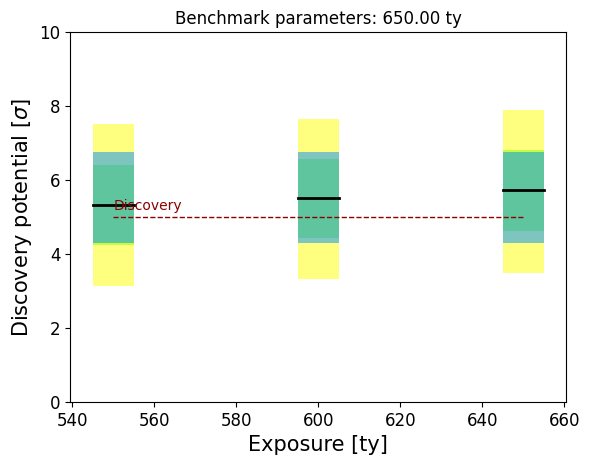

In [31]:
for file, title in files_titles.items():
    produce_plot(file, title)